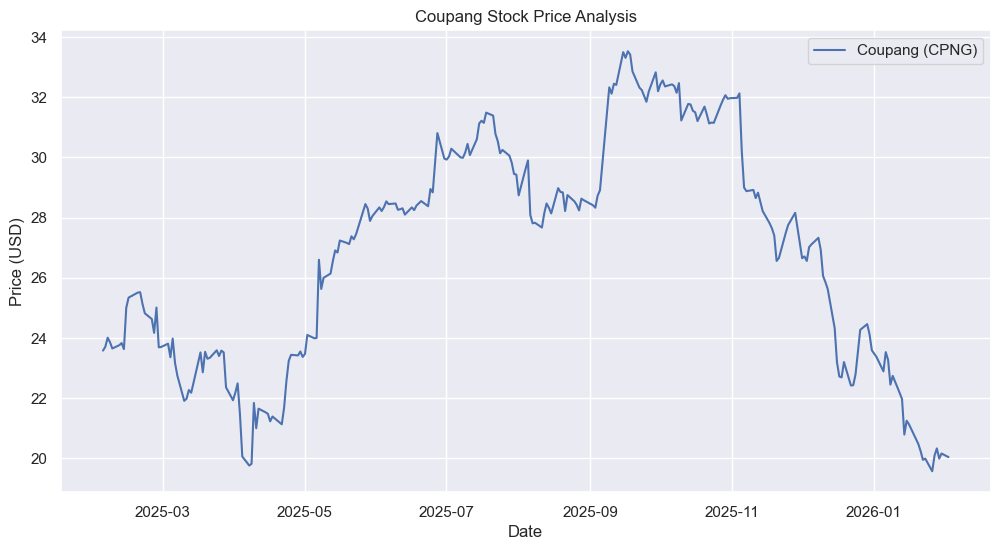

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 데이터 불러오기
# (방금 만든 상대 경로 로직을 활용하거나, 파일명을 직접 지정)
file_path = 'stock_db/CPNG.csv' 

if os.path.exists(file_path):
    df = pd.read_csv(file_path)

    # 2. 날짜 컬럼을 진짜 '날짜 형식'으로 변환
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)

    # 3. 그래프 스타일 설정
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(12, 6))

    # 4. 수정 종가(Adj Close) 그리기
    sns.lineplot(data=df, x=df.index, y='Close', label='Coupang (CPNG)')

    plt.title('Coupang Stock Price Analysis')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()
    
else:
    print("파일이 없습니다. 경로를 확인해주세요!")

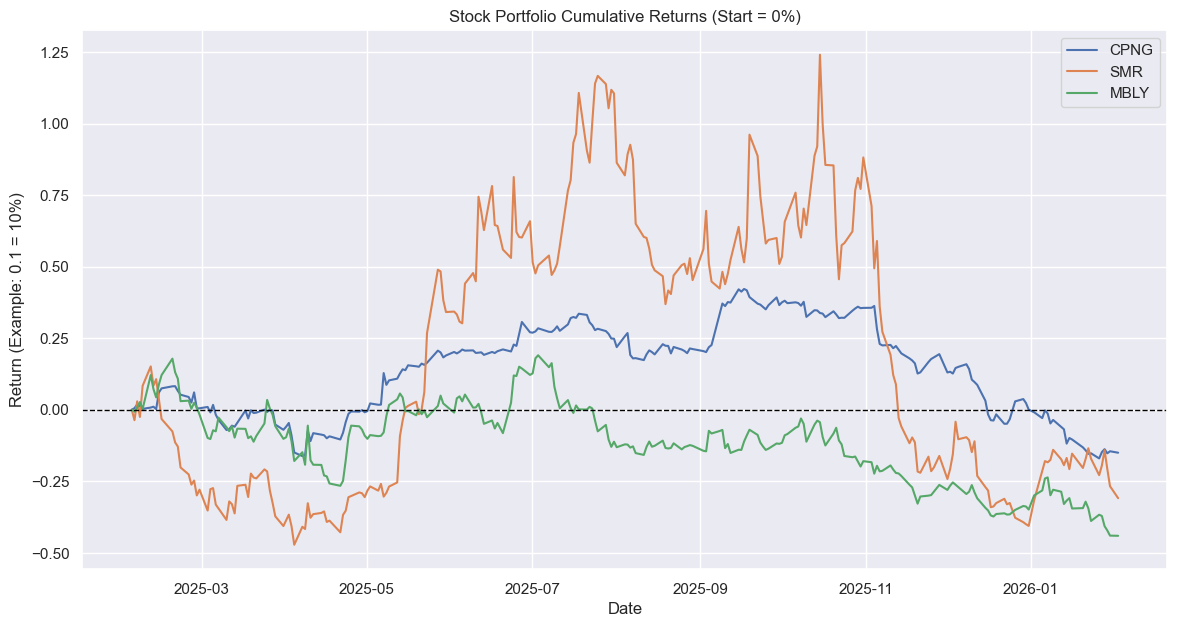

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 종목 리스트 정의
tickers = ['CPNG', 'SMR', 'MBLY']
plt.figure(figsize=(14, 7))

# 2. 반복문으로 데이터 하나씩 꺼내오기
for ticker in tickers:
    file_path = f'stock_db/{ticker}.csv'
    
    if os.path.exists(file_path):
        # 데이터 읽기
        df = pd.read_csv(file_path)
        
        # 날짜 변환 (UTC 필수!)
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        df.set_index('Date', inplace=True)
        
        # [핵심 로직] 누적 수익률 계산 (Cumulative Return)
        # 공식: (현재가격 / 첫날가격) - 1
        # iloc[0]은 첫 번째 행(시작일)의 가격
        first_price = df['Close'].iloc[0]
        df['Return'] = (df['Close'] / first_price) - 1
        
        # 그래프 그리기 (수익률 기준)
        sns.lineplot(data=df, x=df.index, y='Return', label=f'{ticker}')

# 3. 그래프 꾸미기
plt.title('Stock Portfolio Cumulative Returns (Start = 0%)')
plt.xlabel('Date')
plt.ylabel('Return (Example: 0.1 = 10%)')
plt.axhline(0, color='black', linestyle='--', linewidth=1) # 0% 기준선
plt.legend()
plt.show()

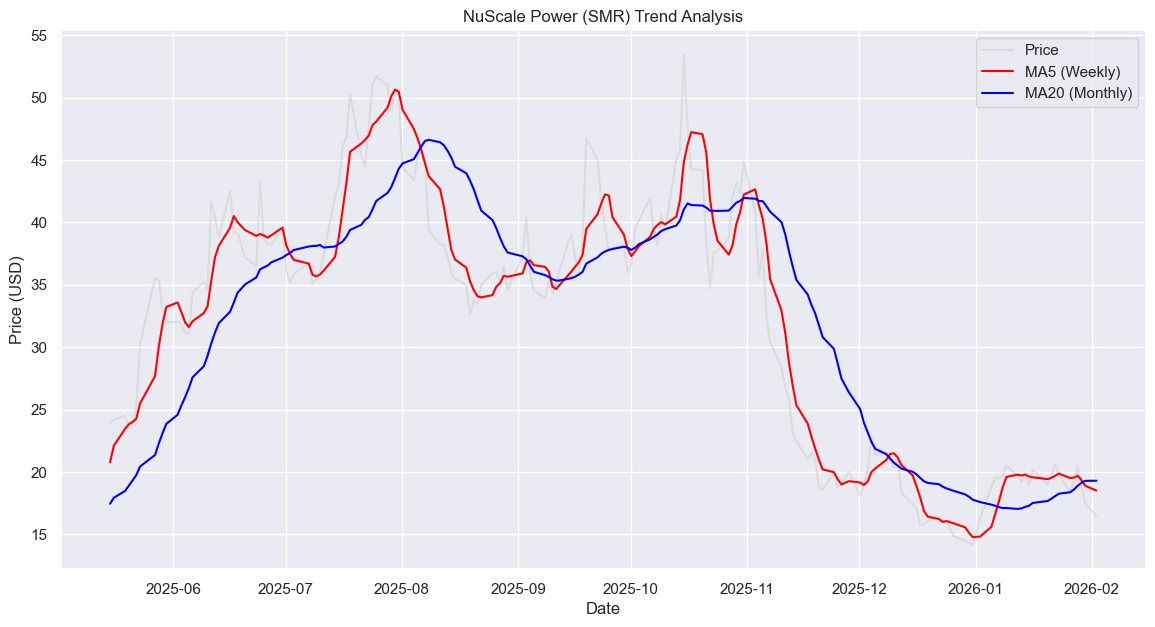

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. 가장 핫한 SMR(뉴스케일)만 집중 분석
file_path = 'stock_db/SMR.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    
    # 날짜 변환 및 정렬
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True) # 날짜 순서대로 정렬 (중요!)

    # [핵심 로직] 이동평균선(MA) 계산
    # rolling(window=5): 5일치 창문을 밀면서 평균을 냄
    df['MA5'] = df['Close'].rolling(window=5).mean()   # 1주일 추세
    df['MA20'] = df['Close'].rolling(window=20).mean() # 1개월 추세

    # 2. 그래프 그리기 (최근 6개월만 확대해서 보기)
    # 데이터가 너무 길면 잘 안보이니, 최근 데이터만 슬라이싱 합니다.
    subset = df.tail(180) 

    plt.figure(figsize=(14, 7))
    
    # 실제 가격 (회색 얇은 선)
    sns.lineplot(data=subset, x=subset.index, y='Close', label='Price', color='lightgray', alpha=0.6)
    
    # 5일선 (빨간색 - 기민하게 움직임)
    sns.lineplot(data=subset, x=subset.index, y='MA5', label='MA5 (Weekly)', color='red', linewidth=1.5)
    
    # 20일선 (파란색 - 묵직하게 움직임)
    sns.lineplot(data=subset, x=subset.index, y='MA20', label='MA20 (Monthly)', color='blue', linewidth=1.5)

    plt.title('NuScale Power (SMR) Trend Analysis')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

else:
    print("데이터 파일이 없습니다.")

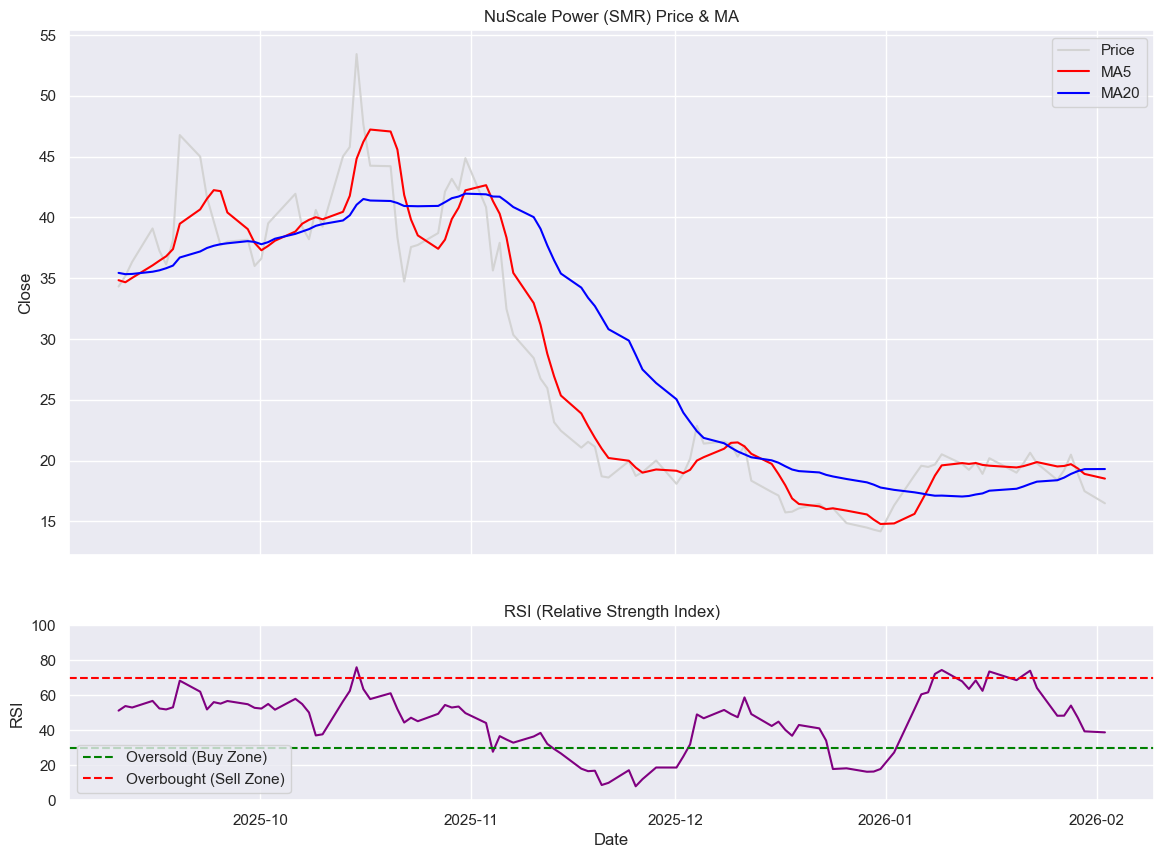

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# 1. 데이터 불러오기
file_path = 'stock_db/SMR.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    # 2. 이동평균선 계산
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()

    # [NEW] 3. RSI(상대강도지수) 계산 로직
    # 공식: 100 - (100 / (1 + RS))
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # --- 시각화 (위: 주가 / 아래: RSI) ---
    subset = df.tail(100) # 최근 100일만 보기

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 위쪽 그래프 (주가 + 이평선)
    sns.lineplot(data=subset, x=subset.index, y='Close', label='Price', color='lightgray', ax=ax1)
    sns.lineplot(data=subset, x=subset.index, y='MA5', label='MA5', color='red', ax=ax1)
    sns.lineplot(data=subset, x=subset.index, y='MA20', label='MA20', color='blue', ax=ax1)
    ax1.set_title('NuScale Power (SMR) Price & MA')
    ax1.legend()

    # 아래쪽 그래프 (RSI)
    sns.lineplot(data=subset, x=subset.index, y='RSI', color='purple', ax=ax2)
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (Buy Zone)') # 30선
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (Sell Zone)') # 70선
    ax2.set_title('RSI (Relative Strength Index)')
    ax2.set_ylim(0, 100) # 0~100 범위 고정
    ax2.legend()

    plt.show()

else:
    print("데이터 파일이 없습니다.")

In [8]:
import pandas as pd
import numpy as np
import os

# 분석할 종목들
tickers = ['CPNG', 'SMR', 'MBLY']

print(f"{'종목':<6} | {'현재가':<8} | {'5일평균':<8} | {'RSI':<6} | {'추천 행동 (Action)':<10}")
print("-" * 60)

for ticker in tickers:
    file_path = f'stock_db/{ticker}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)

        # 1. 이동평균선(MA5) 계산
        df['MA5'] = df['Close'].rolling(window=5).mean()

        # 2. RSI 계산
        delta = df['Close'].diff(1)
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # 3. 가장 최근 데이터(오늘/어제) 가져오기
        today = df.iloc[-1]
        price = today['Close']
        ma5 = today['MA5']
        rsi = today['RSI']

        # 4. 퀀트 알고리즘 (매수 로직)
        action = "WAIT ✋" # 기본값은 대기
        
        # 조건 1: RSI가 40 이하고 (저평가)
        # 조건 2: 현재가가 5일선 위에 있을 때 (추세 전환)
        if rsi < 40 and price > ma5:
            action = "BUY 🚀 (진입 기회!)"
        elif rsi < 30:
            action = "WATCH 👀 (반등 감시)"
        elif rsi > 70:
            action = "SELL 💰 (과열)"

        # 결과 출력
        print(f"{ticker:<6} | {price:<8.2f} | {ma5:<8.2f} | {rsi:<6.1f} | {action}")

종목     | 현재가      | 5일평균     | RSI    | 추천 행동 (Action)
------------------------------------------------------------
CPNG   | 20.04    | 20.12    | 28.7   | WATCH 👀 (반등 감시)
SMR    | 16.48    | 18.51    | 38.8   | WAIT ✋
MBLY   | 8.97     | 9.36     | 23.1   | WATCH 👀 (반등 감시)
